In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

!pip install -q sklearn
!pip install bayesian-optimization
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [79]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as mt
import time
import tensorflow.keras
import tensorflow.keras.initializers
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, precision_score, recall_score, matthews_corrcoef, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adamax, Adagrad, Adadelta
from sklearn.model_selection import KFold
from tensorflow.keras.layers import LeakyReLU,PReLU, ELU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer, BatchNormalization, concatenate, Input, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, TimeDistributed, Reshape, GlobalMaxPooling1D, GlobalMaxPool1D, AvgPool1D
from tensorflow.keras import regularizers
import time
import warnings

documents_id = '1Z4mHE2N8Jy7Zjd4jZ973HtPHu8-JhhlQ'
documents_name = 'google_drive_documents_ids.csv'

def r_square(y_true, y_pred):
  from keras import backend as K
  SS_res = K.sum(K.square(y_pred - y_true))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  R2 = 1 - SS_res/(SS_tot + K.epsilon())
  return R2

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [3]:
def get_datasets(set_name,encoding,df):
  ids=[]
  filenames=[]
  PCprops = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
  if encoding=='onehot':
    ids = [df[df['Unnamed: 0']==set_name]['One_hot'].iloc[0]]
    filenames = ['One_hot ' + set_name + '.csv']
  elif encoding=='ordinal':
    ids = [df[df['Unnamed: 0']==set_name]['Ordinal'].iloc[0]]
    filenames = ['Ordinal ' + set_name + '.csv']
  elif encoding=='AAC':
    ids = [df[df['Unnamed: 0']==set_name]['AAC'].iloc[0]]
    filenames = ['AAC ' + set_name + '.csv']
  elif encoding=='dipeptide_comp':
    ids = [df[df['Unnamed: 0']==set_name]['dipeptide_comp'].iloc[0]]
    filenames = ['dipeptide_comp ' + set_name + '.csv']
  elif encoding=='all digitalizations':
    for prop in PCprops:
      ids += [df[df['Unnamed: 0']==set_name]['digitalization ' + prop].iloc[0]]
      filenames += ['digitalization ' + prop + ' ' + set_name + '.csv']
  elif PCprops.count(encoding)==1:
    ids = [df[df['Unnamed: 0']==set_name]['digitalization ' + encoding].iloc[0]]
    filenames = ['digitalization ' + encoding + ' ' + set_name + '.csv']
  for i in range(0,len(ids)):
    documents_file = drive.CreateFile({'id':ids[i]})
    documents_file.GetContentFile(filenames[i])
  return ids, filenames

In [4]:
def read_dataframes(filenames):
  dfs = []
  for filename in filenames:
    df = pd.read_csv(filename)
    dfs += [df]
  return dfs


In [40]:
def knn_mod(dataframe, problemtype, kfold_CV=True, kmin=1, kmax=20, verb=1, K=1, target_names=['clase 0','clase 1']):
  df = dataframe
  if problemtype=='regression':
      df = df[df['response'].notna()]
  df = df.sample(frac=1).reset_index(drop=True)
  #samples = len(df['p0'])

  verbosity = 1
  columns = df.columns.tolist()
  samples = len(df[columns[1]])

  if problemtype=='multiclass':
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  if problemtype=='binary_class' and isinstance(df['class'].iloc[0],str):
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  # Split training and external validation set, establish number of k-folds for internal validation
  if samples > 100 and samples <= 500:
    dtrain, deval = train_test_split(df, test_size=0.3)
    num_folds = 10
  elif samples > 500:
    dtrain, deval = train_test_split(df, test_size=0.2)
    num_folds = 5
  elif samples <= 100:
    dtrain = df
    deval = []
    num_folds = samples

  # Determine shape of the data
  input_shape = (len(columns)-1, )

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Seperate inputs and target values
  target_train = dtrain.pop(columns[0])
  input_train = dtrain.astype('float64')/dtrain.max().max()
  target_test = deval.pop(columns[0])
  input_test = deval.astype('float64')/dtrain.max().max()

  if kfold_CV==True:
    k_range = range(kmin, kmax+1)
    # K-fold Cross Validation model procedure
    if problemtype=='binary_class' or problemtype=='multiclass':
      k_scores = [[],[],[],[],[],[],[],[]]
      for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        if problemtype=='binary_class':
          p = 'precision'
          r = 'recall'
          f1 = 'f1'
        elif problemtype=='multiclass':
          f1 = 'f1_weighted'
          p = 'precision_weighted'
          r = 'recall_weighted'
        scores = cross_validate(knn, input_train, target_train, cv=num_folds, scoring=('accuracy', p, r, f1), verbose=verb)
        k_scores[0] += [scores['test_accuracy'].mean()]
        k_scores[1] += [scores['test_accuracy'].std()]
        k_scores[2] += [scores['test_'+p].mean()]
        k_scores[3] += [scores['test_'+p].std()]
        k_scores[4] += [scores['test_'+r].mean()]
        k_scores[5] += [scores['test_'+r].std()]
        k_scores[6] += [scores['test_'+f1].mean()]
        k_scores[7] += [scores['test_'+f1].std()]
      score_dict = ['accuracy','precision','recall',f1]
      return k_scores
    elif problemtype=='regression':
      k_scores = [[],[],[],[]]
      for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_validate(knn, input_train, target_train, cv=num_folds, scoring=('neg_mean_squared_error', 'r2'), verbose=verb)
        k_scores[0] += [scores['test_neg_mean_squared_error'].mean()]
        k_scores[1] += [scores['test_neg_mean_squared_error'].std()]
        k_scores[2] += [scores['test_r2'].mean()]
        k_scores[3] += [scores['test_r2'].std()]
      return k_scores

  elif kfold_CV==False:
    target_test = np.array(target_test.tolist())
    if problemtype=='binary_class' or problemtype=='multiclass':
      if problemtype=='multiclass':
        c='balanced'
      else:
        c=None
      knn = KNeighborsClassifier(n_neighbors=K)
      knn.fit(input_train,target_train)
      y_pred = knn.predict(input_test)
      print(confusion_matrix(target_test,y_pred))
      score = accuracy_score(target_test,y_pred)
    elif problemtype=='regression':
      knn = KNeighborsRegressor(n_neighbors=K)
      knn.fit(input_train,target_train)
      y_pred = knn.predict(input_test)
      R2 = r2_score(target_test,y_pred)
      return R2



def rf_mod(dataframe, problemtype, kfold_CV=True, ntree=200, bootstrap=False,
           max_features='auto', min_samples_leaf=1, min_samples_split=2,verb=1, n_jobs=None, class_weight=None):
  df = dataframe
  if problemtype=='regression':
      df = df[df['response'].notna()]
  #samples = len(df['p0'])

  verbosity = 1
  columns = df.columns.tolist()
  samples = len(df[columns[1]])

  if problemtype=='multiclass':
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  df = df.sample(frac=1).reset_index(drop=True)

  # Split training and external validation set, establish number of k-folds for internal validation
  if samples > 100 and samples <= 500:
    dtrain, deval = train_test_split(df, test_size=0.3)
    num_folds = 10
  elif samples > 500:
    dtrain, deval = train_test_split(df, test_size=0.2)
    num_folds = 5
  elif samples <= 100:
    dtrain = df
    deval = []
    num_folds = samples

  # Determine shape of the data
  input_shape = (len(columns)-1, )

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Seperate inputs and target values
  target_train = dtrain.pop(columns[0])
  input_train = dtrain.astype('float64')/dtrain.max().max()
  target_test = deval.pop(columns[0])
  input_test = deval.astype('float64')/dtrain.max().max()

  if kfold_CV==True:
    # K-fold Cross Validation model procedure
    if problemtype=='binary_class' or problemtype=='multiclass':
      rf_scores = [[],[],[],[],[],[],[],[]]
      rf = RandomForestClassifier(n_estimators=ntree, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)
      if problemtype=='binary_class':
        p = 'precision'
        r = 'recall'
        f1 = 'f1'
      elif problemtype=='multiclass':
        f1 = 'f1_weighted'
        p = 'precision_weighted'
        r = 'recall_weighted'
      scores = cross_validate(rf, input_train, target_train, cv=num_folds, scoring=('accuracy', p, r, f1),verbose=verb, n_jobs=n_jobs)
      rf_scores[0] += [scores['test_accuracy'].mean()]
      rf_scores[1] += [scores['test_accuracy'].std()]
      rf_scores[2] += [scores['test_'+p].mean()]
      rf_scores[3] += [scores['test_'+p].std()]
      rf_scores[4] += [scores['test_'+r].mean()]
      rf_scores[5] += [scores['test_'+r].std()]
      rf_scores[6] += [scores['test_'+f1].mean()]
      rf_scores[7] += [scores['test_'+f1].std()]
      return rf_scores
    elif problemtype=='regression':
      rf_scores = [[],[],[],[]]
      rf = RandomForestRegressor(n_estimators=ntree, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
      scores = cross_validate(rf, input_train, target_train, cv=num_folds, scoring=('neg_mean_squared_error', 'r2'), verbose=verb, n_jobs=n_jobs)
      rf_scores[0] += [scores['test_neg_mean_squared_error'].mean()]
      rf_scores[1] += [scores['test_neg_mean_squared_error'].std()]
      rf_scores[2] += [scores['test_r2'].mean()]
      rf_scores[3] += [scores['test_r2'].std()]
      return rf_scores

  elif kfold_CV==False:
    target_test = np.array(target_test.tolist())
    if problemtype=='binary_class' or problemtype=='multiclass':
      if problemtype=='multiclass':
        c='balanced'
      else:
        c=None
      rf = RandomForestClassifier(n_estimators=ntree, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
      rf.fit(input_train,target_train)
      y_pred = rf.predict(input_test)
      print('y_pred:')
      print(y_pred)
      print('target_test:')
      print(target_test)
      score = accuracy_score(target_test,y_pred)
      return score
    elif problemtype=='regression':
      rf = RandomForestRegressor(n_estimators=ntree, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
      rf.fit(input_train,target_train)
      y_pred = rf.predict(input_test)
      R2 = r2_score(target_test,y_pred)
      return R2



def svm_mod(dataframe, problemtype, kfold_CV=True, C=1, kernel='rbf', gamma='scale', verb=1, n_jobs=None):
  df = dataframe
  if problemtype=='regression':
      df = df[df['response'].notna()]
  df = df.sample(frac=1).reset_index(drop=True)
  #samples = len(df['p0'])

  verbosity = 1
  columns = df.columns.tolist()
  samples = len(df[columns[1]])

  if problemtype=='multiclass':
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  # Split training and external validation set, establish number of k-folds for internal validation
  if samples > 100 and samples <= 500:
    dtrain, deval = train_test_split(df, test_size=0.3)
    num_folds = 10
  elif samples > 500:
    dtrain, deval = train_test_split(df, test_size=0.2)
    num_folds = 5
  elif samples <= 100:
    dtrain = df
    deval = []
    num_folds = samples

  # Determine shape of the data
  input_shape = (len(columns)-1, )

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Seperate inputs and target values
  target_train = dtrain.pop(columns[0])
  input_train = dtrain.astype('float64')/dtrain.max().max()
  target_test = deval.pop(columns[0])
  input_test = deval.astype('float64')/dtrain.max().max()

  if kfold_CV==True:
    if problemtype=='binary_class' or problemtype=='multiclass':
      sv_scores = [[],[],[],[],[],[],[],[]]
      sv = SVC(C=C, kernel=kernel, gamma=gamma, verbose=verb, class_weight='balanced')
      if problemtype=='binary_class':
        p = 'precision'
        r = 'recall'
        f1 = 'f1'
      elif problemtype=='multiclass':
        f1 = 'f1_weighted'
        p = 'precision_weighted'
        r = 'recall_weighted'
      scores = cross_validate(sv, input_train, target_train, cv=num_folds, scoring=('accuracy', p, r, f1),verbose=verb, n_jobs=n_jobs)
      sv_scores[0] += [scores['test_accuracy'].mean()]
      sv_scores[1] += [scores['test_accuracy'].std()]
      sv_scores[2] += [scores['test_'+p].mean()]
      sv_scores[3] += [scores['test_'+p].std()]
      sv_scores[4] += [scores['test_'+r].mean()]
      sv_scores[5] += [scores['test_'+r].std()]
      sv_scores[6] += [scores['test_'+f1].mean()]
      sv_scores[7] += [scores['test_'+f1].std()]
      return sv_scores
    elif problemtype=='regression':
      sv_scores = [[],[],[],[]]
      sv = SVR(C=C, kernel=kernel, gamma=gamma, verbose=verb)
      scores = cross_validate(sv, input_train, target_train, cv=num_folds, scoring=('neg_mean_squared_error', 'r2'), verbose=verb, n_jobs=n_jobs)
      sv_scores[0] += [scores['test_neg_mean_squared_error'].mean()]
      sv_scores[1] += [scores['test_neg_mean_squared_error'].std()]
      sv_scores[2] += [scores['test_r2'].mean()]
      sv_scores[3] += [scores['test_r2'].std()]
      return sv_scores

  elif kfold_CV==False:
    target_test = np.array(target_test.tolist())
    if problemtype=='binary_class' or problemtype=='multiclass':
      if problemtype=='multiclass':
        c='balanced'
      else:
        c=None
      sv = SVC(C=C, kernel=kernel, gamma=gamma, verbose=verb, class_weight=c)
      sv.fit(input_train,target_train)
      y_pred = sv.predict(input_test)
      score = accuracy_score(target_test,y_pred)
      return score
    elif problemtype=='regression':
      sv = SVR(C=C, kernel=kernel, gamma=gamma, verbose=verb)
      sv.fit(input_train,target_train)
      y_pred = sv.predict(input_test)
      R2 = r2_score(target_test,y_pred)
      return R2



In [128]:

def fftpredict(dataframe, modeltype, problemtype, kfold_CV=True, dropout=0.2, lr=1e-4, loss_class='sparse_categorical_crossentropy', 
               loss_reg='mse', stopmetric='val_loss', patience=200, epochs=1000, batch_size=32,
               optimizer=Adam, metrics=['accuracy'], min_delta=1e-3):

  df = dataframe
  if problemtype=='regression':
      df = df[df['response'].notna()]
  df = df.sample(frac=1).reset_index(drop=True)
  #samples = len(df['p0'])

  verbosity = 1
  columns = df.columns.tolist()
  samples = len(df[columns[1]])

  if df.columns[0]=='class':
    no_outputs = len(df['class'].unique())
  elif df.columns[0]=='response':
    no_outputs = 1

  if problemtype=='multiclass':
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  # Split training and external validation set, establish number of k-folds for internal validation
  if samples > 100 and samples <= 500:
    dtrain, deval = train_test_split(df, test_size=0.3)
    num_folds = 10
  elif samples > 500:
    dtrain, deval = train_test_split(df, test_size=0.2)
    num_folds = 5
  elif samples <= 100:
    dtrain = df
    deval = []
    num_folds = samples

  # Determine shape of the data
  input_shape = (len(columns)-1, )

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Seperate inputs and target values
  target_train = dtrain.pop(columns[0])
  input_train = dtrain.astype('float64')/dtrain.max().max()
  target_eval = deval.pop(columns[0])
  input_eval = deval.astype('float64')/dtrain.max().max()


  def generate_model(dropout,modeltype,problemtype):
    if modeltype=='ANN':
      inp = Input(shape=input_shape)
      model = Dense(256, activation='relu')(inp)
      model = Dropout(dropout)(model)
      #model = BatchNormalization()(model)
      model = Dense(128, activation='relu')(model)
      model = Dense(16, activation='relu')(model) 
      model = Dropout(dropout)(model)
    elif modeltype=='LSTM':
      inp = Input(shape=(dtrain.shape[1],1))
      model = Bidirectional(LSTM(64, return_sequences =True, dropout=dropout))(inp)
      model = Dense(16, activation='relu')(model)
      model = Dropout(dropout)(model)
    elif modeltype=='CNN':
      inp = Input(shape=(dtrain.shape[1],1))
      model = Conv1D(filters=256, kernel_size=3, activation='relu')(inp)
      model = MaxPooling1D(pool_size=2)(model)
      model = Dropout(dropout)(model)
      model = Conv1D(filters=128, kernel_size=3, activation='relu')(model)
      model = MaxPooling1D(pool_size=2)(model)
      model = Dropout(dropout)(model)
      model = Flatten()(model)
      model = Dense(16, activation='relu')(model)
    if problemtype=='binary_class':
      model = Dense(2)(model)
      out = Activation('softmax')(model)
    elif problemtype=='multiclass':
      model = Dense(6)(model)
      out = Activation('softmax')(model)
    elif problemtype=='regression':
      out = Dense(1)(model)
    final = Model(inputs=[inp], outputs=[out])
    return final    

  def evaluate_complete_model(modeltype, problemtype, kfold_CV, dropout, lr,
                              loss_class, loss_reg, stopmetric, patience, epochs, batch_size, optimizer, metrics, min_delta):
    batch_size = batch_size
    epochs_needed = []
    num = 0
    acc_per_fold = [] #acc or R2
    loss_per_fold = []
    start_time = time.time()

    if kfold_CV==True:
      # K-fold Cross Validation model procedure
      fold_no = 1
      for train, internal_test in kfold.split(input_train, target_train):
        num+=1

        # Model architect and hyperparameters establishment
        model = generate_model(dropout,modeltype,problemtype)
        if problemtype=='binary_class' or problemtype=='multiclass':
          loss=loss_class
        elif problemtype=='regression':
          loss=loss_reg
        if stopmetric=='val_r_square':
          mode = 'max'
        else:
          mode = 'auto'
        model.compile(loss=loss, optimizer=optimizer(lr=lr), metrics=metrics)
        monitor = EarlyStopping(monitor=stopmetric, min_delta=min_delta, 
        patience=patience, verbose=0, mode=mode, restore_best_weights=True)

        # Define training and validation subset within specific kfold set
        x_train = input_train.iloc[train]
        y_train = target_train.iloc[train]
        x_test = input_train.iloc[internal_test]
        y_test = target_train.iloc[internal_test]

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Train on the kfold sample
        model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor], epochs=epochs, batch_size=batch_size, verbose=verbosity)
        epochs_end = monitor.stopped_epoch
        epochs_needed.append(epochs_end)

        # Generate generalization metrics
        scores = model.evaluate(x_test, y_test, verbose=0)
        if problemtype=='regression':
          print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
          C = 1
        else:
          print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
          C = 100
        acc_per_fold.append(scores[1] * C)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

      time_took = time.time() - start_time
      print(f'time took for kfold_CV: {time_took}')

      # Provide average scores      
      m1 = np.mean(loss_per_fold)
      m2 = np.mean(acc_per_fold)
      m3 = np.mean(epochs_needed)
      m1dev = np.std(loss_per_fold)
      m2dev = np.std(acc_per_fold)
      m3dev = np.std(epochs_needed)
      scores2 = model.evaluate(input_eval,target_eval)
      if problemtype=='regression':
        print(f'loss: {m1} +- {m1dev}, error: {m2} +- {m2dev}, epochs: {m3} +- {m3dev}, test error: {scores2[1]}')
      else:
        print(f'loss: {m1} +- {m1dev}, accuracy: {m2} +- {m2dev}, epochs: {m3} +- {m3dev}, test acc: {scores2[1]*100}')
      tensorflow.keras.backend.clear_session()
      stat = [m1,m1dev,m2,m2dev,m3,m3dev]
      return stat

    elif kfold_CV==False:
      start_time = time.time()
      model = generate_model(dropout,modeltype,problemtype)
      if problemtype=='binary_class' or problemtype=='multiclass':
        loss=loss_class
      elif problemtype=='regression':
        loss=loss_reg
      model.compile(loss=loss, optimizer=optimizer(lr=lr), metrics=metrics)
      monitor = EarlyStopping(monitor=stopmetric, min_delta=min_delta, 
                              patience=patience, verbose=1, mode='auto', restore_best_weights=True)
      x_train = input_train
      y_train = target_train
      x_test = input_eval
      y_test = target_eval

      class_weight = {0: 1/0.203,
                      1: 1/0.037,
                      2: 1/0.096,
                      3: 1/0.023,
                      4: 1/0.033,
                      5: 1/0.609}

      history = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test), callbacks=[monitor], epochs=epochs, batch_size=batch_size, verbose=verbosity, class_weight=class_weight)

      y_pred = model.predict(x_test)
      #y_pred = np.array([round(y_pred[i,1]) for i in range(0,len(y_pred[:,1]))]).transpose()
      y_pred2 = []
      for i in range(0,len(y_pred[:,0])):
        ind = y_pred[i,:].tolist().index(max(y_pred[i,:].tolist()))
        y_pred2 += [ind]
      y_pred = np.array(y_pred2).transpose()
      #print(y_pred)
      y_pred_keras = model.predict(x_test)
      fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras[:,1])
      #model.evaluate(x_test, y_test, verbose=0)
      from sklearn.metrics import auc
      auc_keras = auc(fpr_keras, tpr_keras)
      plt.figure(1)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f})'.format(auc_keras))
      plt.grid()
      plt.xlabel('False positive rate', fontsize=12)
      plt.ylabel('True positive rate',fontsize=12)
      plt.title('Curva ROC para DBP', fontsize=14)

      plt.legend(loc='best')
      plt.show()
      #print(confusion_matrix(y_test,y_pred))
      A = [fpr_keras, tpr_keras]
      return A

      #time_took = time.time() - start_time
      #print(f'time took for training on whole set: {time_took}')

  A = evaluate_complete_model(modeltype, problemtype, kfold_CV, dropout, lr, 
                              loss_class, loss_reg, stopmetric, patience, epochs, batch_size, optimizer, metrics, min_delta)
  return A

In [75]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
documents_file = drive.CreateFile({'id':documents_id})
documents_file.GetContentFile(documents_name)
documents_id_df = pd.read_csv(documents_name)

In [130]:
dataset_name = 'DBP'
encoding = 'all digitalizations'
ids, filenames = get_datasets(dataset_name,encoding,documents_id_df)
dfs = read_dataframes(filenames)

In [80]:
problemtype = 'binary_class'
modeltype = 'CNN'
#stopmetric = 'val_r_square'
#metrics = [r_square]
stopmetric = 'val_accuracy'
metrics=['accuracy']#, f1_m, precision_m, recall_m, matthews_correlation]
d = 1e-3

Epoch 1/700
26/26 [==============================] - 0s 15ms/step - loss: 9.8117 - accuracy: 0.5006 - val_loss: 0.8705 - val_accuracy: 0.4466
Epoch 2/700
26/26 [==============================] - 0s 4ms/step - loss: 7.8494 - accuracy: 0.5018 - val_loss: 1.1185 - val_accuracy: 0.4466
Epoch 3/700
26/26 [==============================] - 0s 4ms/step - loss: 7.4529 - accuracy: 0.5018 - val_loss: 1.0813 - val_accuracy: 0.4466
Epoch 4/700
26/26 [==============================] - 0s 4ms/step - loss: 7.1512 - accuracy: 0.5018 - val_loss: 1.0320 - val_accuracy: 0.4466
Epoch 5/700
26/26 [==============================] - 0s 4ms/step - loss: 6.8212 - accuracy: 0.5018 - val_loss: 1.0189 - val_accuracy: 0.4466
Epoch 6/700
26/26 [==============================] - 0s 4ms/step - loss: 6.5247 - accuracy: 0.5018 - val_loss: 1.0077 - val_accuracy: 0.4466
Epoch 7/700
26/26 [==============================] - 0s 4ms/step - loss: 6.4487 - accuracy: 0.5018 - val_loss: 1.0271 - val_accuracy: 0.4466
Epoch 8/700


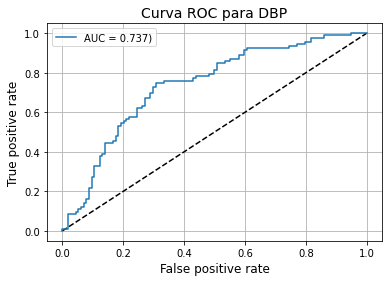

accruacy:


In [132]:
A = fftpredict(dfs[1], modeltype, problemtype, kfold_CV=False, dropout=0.2, lr=5e-4, loss_class='sparse_categorical_crossentropy',
                                                         loss_reg='mse', stopmetric=stopmetric, patience=200, epochs=700, batch_size=32,
                                                         optimizer=Adam, metrics=metrics, min_delta=d)
print('accruacy:')


In [50]:
#for i in [1e-2,1e-3,1,1e+1,1e+2,1e+3]:
for i in range(1,2):
  #scores_0 = rf_mod(dfs[4], problemtype, kfold_CV=False, ntree=200, n_jobs=-1, bootstrap=True,
 #                       max_features=14, min_samples_leaf=1, min_samples_split=2,verb=1)
  #scores_0 = svm_mod(dfs[6], problemtype, kfold_CV=False, C=400, kernel='rbf', gamma=1e+2, verb=1, n_jobs=-1)
  scores_0 = knn_mod(dfs[1], problemtype, kfold_CV=False, kmin=1, kmax=20, K=3)
  print(f'property {i}:')
  #print(max(scores_0[0]))
  #ind = scores_0[2].index(max(scores_0[2]))
  #print(scores_0[3][ind])
  #A = [i for i in range(1,21)]
  #plt.plot(A,scores_0[2],'-b')
  #plt.plot(A,scores_0[3],'-r')
  #plt.show()
  #print(A[ind])
  print(scores_0)
  print('-------------------------------------------------------')

[[ 83   9  30   2   1  28]
 [ 12   7   1   0   0   1]
 [ 56   0   3   1   1  10]
 [ 10   4   0   0   3   0]
 [ 13   1   0   3   0   0]
 [ 65   2   8   2   0 404]]
property 1:
None
-------------------------------------------------------


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

!pip install -q sklearn
!pip install bayesian-optimization
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as mt
import time
import tensorflow.keras
import tensorflow.keras.initializers
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adamax, Adagrad, Adadelta
from sklearn.model_selection import KFold
from tensorflow.keras.layers import LeakyReLU,PReLU, ELU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer, BatchNormalization, concatenate, Input, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, TimeDistributed, Reshape, GlobalMaxPooling1D, GlobalMaxPool1D, AvgPool1D
from tensorflow.keras import regularizers
import time
import warnings

documents_id = '1Z4mHE2N8Jy7Zjd4jZ973HtPHu8-JhhlQ'
documents_name = 'google_drive_documents_ids.csv'

def r_square(y_true, y_pred):
  from keras import backend as K
  SS_res = K.sum(K.square(y_pred - y_true))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  R2 = 1 - SS_res/(SS_tot + K.epsilon())
  return R2

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def get_datasets(set_name,encoding,df):
  ids=[]
  filenames=[]
  PCprops = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
  if encoding=='onehot':
    ids = [df[df['Unnamed: 0']==set_name]['One_hot'].iloc[0]]
    filenames = ['One_hot ' + set_name + '.csv']
  elif encoding=='ordinal':
    ids = [df[df['Unnamed: 0']==set_name]['Ordinal'].iloc[0]]
    filenames = ['Ordinal ' + set_name + '.csv']
  elif encoding=='AAC':
    ids = [df[df['Unnamed: 0']==set_name]['AAC'].iloc[0]]
    filenames = ['AAC ' + set_name + '.csv']
  elif encoding=='dipeptide_comp':
    ids = [df[df['Unnamed: 0']==set_name]['dipeptide_comp'].iloc[0]]
    filenames = ['dipeptide_comp ' + set_name + '.csv']
  elif encoding=='all digitalizations':
    for prop in PCprops:
      ids += [df[df['Unnamed: 0']==set_name]['digitalization ' + prop].iloc[0]]
      filenames += ['digitalization ' + prop + ' ' + set_name + '.csv']
  elif PCprops.count(encoding)==1:
    ids = [df[df['Unnamed: 0']==set_name]['digitalization ' + encoding].iloc[0]]
    filenames = ['digitalization ' + encoding + ' ' + set_name + '.csv']
  for i in range(0,len(ids)):
    documents_file = drive.CreateFile({'id':ids[i]})
    documents_file.GetContentFile(filenames[i])
  return ids, filenames


def read_dataframes(filenames):
  dfs = []
  for filename in filenames:
    df = pd.read_csv(filename)
    dfs += [df]
  return dfs

def fftpredict(dataframe, modeltype, problemtype, kfold_CV=True, dropout=0.2, lr=1e-4, loss_class='sparse_categorical_crossentropy', 
               loss_reg='mse', stopmetric='val_loss', patience=200, epochs=1000, batch_size=32,
               optimizer=Adam, metrics=['accuracy'], min_delta=1e-3):

  df = dataframe
  if problemtype=='regression':
      df = df[df['response'].notna()]
  df = df.sample(frac=1).reset_index(drop=True)

  verbosity = 1
  columns = df.columns.tolist()
  samples = len(df[columns[1]])

  if df.columns[0]=='class':
    no_outputs = len(df['class'].unique())
  elif df.columns[0]=='response':
    no_outputs = 1

  if problemtype=='multiclass':
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  # Split training and external validation set, establish number of k-folds for internal validation
  if samples > 100 and samples <= 500:
    dtrain, deval = train_test_split(df, test_size=0.3)
    num_folds = 10
  elif samples > 500:
    dtrain, deval = train_test_split(df, test_size=0.2)
    num_folds = 5
  elif samples <= 100:
    dtrain = df
    deval = []
    num_folds = samples

  # Determine shape of the data
  input_shape = (len(columns)-1, )

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Seperate inputs and target values
  target_train = dtrain.pop(columns[0])
  input_train = dtrain.astype('float64')/dtrain.max().max()
  target_eval = deval.pop(columns[0])
  input_eval = deval.astype('float64')/dtrain.max().max()


  def generate_model(dropout,modeltype,problemtype):
    if modeltype=='ANN':
      inp = Input(shape=input_shape)
      model = Dense(256, activation='relu')(inp)
      model = Dropout(dropout)(model)
      model = Dense(128, activation='relu')(model)
      model = Dense(16, activation='relu')(model) 
      model = Dropout(dropout)(model)
    elif modeltype=='LSTM':
      inp = Input(shape=(dtrain.shape[1],1))
      model = Bidirectional(LSTM(64, return_sequences =True, dropout=dropout))(inp)
      model = Dense(16, activation='relu')(model)
      model = Dropout(dropout)(model)
    elif modeltype=='CNN':
      inp = Input(shape=(dtrain.shape[1],1))
      model = Conv1D(filters=256, kernel_size=3, activation='relu')(inp)
      model = MaxPooling1D(pool_size=2)(model)
      model = Dropout(dropout)(model)
      model = Conv1D(filters=128, kernel_size=3, activation='relu')(model)
      model = MaxPooling1D(pool_size=2)(model)
      model = Dropout(dropout)(model)
      model = Flatten()(model)
      model = Dense(16, activation='relu')(model)
    if problemtype=='binary_class':
      model = Dense(2)(model)
      out = Activation('softmax')(model)
    elif problemtype=='multiclass':
      model = Dense(6)(model)
      out = Activation('softmax')(model)
    elif problemtype=='regression':
      out = Dense(1)(model)
    final = Model(inputs=[inp], outputs=[out])
    return final    

  def evaluate_complete_model(modeltype, problemtype, kfold_CV, dropout, lr,
                              loss_class, loss_reg, stopmetric, patience, epochs, batch_size, optimizer, metrics, min_delta):
    batch_size = batch_size
    epochs_needed = []
    num = 0
    acc_per_fold = [] #acc or R2
    loss_per_fold = []
    start_time = time.time()

    if kfold_CV==True:
      # K-fold Cross Validation model procedure
      fold_no = 1
      for train, internal_test in kfold.split(input_train, target_train):
        num+=1

        # Model architect and hyperparameters establishment
        model = generate_model(dropout,modeltype,problemtype)
        if problemtype=='binary_class' or problemtype=='multiclass':
          loss=loss_class
        elif problemtype=='regression':
          loss=loss_reg
        if stopmetric=='val_r_square':
          mode = 'max'
        else:
          mode = 'auto'
        model.compile(loss=loss, optimizer=optimizer(lr=lr), metrics=metrics)
        monitor = EarlyStopping(monitor=stopmetric, min_delta=min_delta, 
        patience=patience, verbose=0, mode=mode, restore_best_weights=True)

        # Define training and validation subset within specific kfold set
        x_train = input_train.iloc[train]
        y_train = target_train.iloc[train]
        x_test = input_train.iloc[internal_test]
        y_test = target_train.iloc[internal_test]

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Train on the kfold sample
        model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor], epochs=epochs, batch_size=batch_size, verbose=verbosity)
        epochs_end = monitor.stopped_epoch
        epochs_needed.append(epochs_end)

        # Generate generalization metrics
        scores = model.evaluate(x_test, y_test, verbose=0)
        if problemtype=='regression':
          print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
          C = 1
        else:
          print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
          C = 100
        acc_per_fold.append(scores[1] * C)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

      time_took = time.time() - start_time
      print(f'time took for kfold_CV: {time_took}')

      # Provide average scores      
      m1 = np.mean(loss_per_fold)
      m2 = np.mean(acc_per_fold)
      m3 = np.mean(epochs_needed)
      m1dev = np.std(loss_per_fold)
      m2dev = np.std(acc_per_fold)
      m3dev = np.std(epochs_needed)
      scores2 = model.evaluate(input_eval,target_eval)
      if problemtype=='regression':
        print(f'loss: {m1} +- {m1dev}, error: {m2} +- {m2dev}, epochs: {m3} +- {m3dev}, test error: {scores2[1]}')
      else:
        print(f'loss: {m1} +- {m1dev}, accuracy: {m2} +- {m2dev}, epochs: {m3} +- {m3dev}, test acc: {scores2[1]*100}')
      tensorflow.keras.backend.clear_session()
      stat = [m1,m1dev,m2,m2dev,m3,m3dev]
      return stat

    elif kfold_CV==False:
      start_time = time.time()
      model = generate_model(dropout,modeltype,problemtype)
      if problemtype=='binary_class' or problemtype=='multiclass':
        loss=loss_class
      elif problemtype=='regression':
        loss=loss_reg
      model.compile(loss=loss, optimizer=optimizer(lr=lr), metrics=metrics)
      monitor = EarlyStopping(monitor=stopmetric, min_delta=min_delta, 
                              patience=patience, verbose=1, mode='auto', restore_best_weights=True)
      x_train = input_train
      y_train = target_train
      x_test = input_eval
      y_test = target_eval

      history = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test), callbacks=[monitor], epochs=epochs, batch_size=batch_size, verbose=verbosity)

      time_took = time.time() - start_time
      print(f'time took for training on whole set: {time_took}')

  print(evaluate_complete_model(modeltype, problemtype, kfold_CV, dropout, lr, 
                          loss_class, loss_reg, stopmetric, patience, epochs, batch_size, optimizer, metrics, min_delta))
  

def knn_mod(dataframe, problemtype, kfold_CV=True, kmin=1, kmax=20, verb=1, K=1, target_names=['clase 0','clase 1']):
  df = dataframe
  if problemtype=='regression':
      df = df[df['response'].notna()]
  df = df.sample(frac=1).reset_index(drop=True)
  #samples = len(df['p0'])

  verbosity = 1
  columns = df.columns.tolist()
  samples = len(df[columns[1]])

  if problemtype=='multiclass':
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  if problemtype=='binary_class' and isinstance(df['class'].iloc[0],str):
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  # Split training and external validation set, establish number of k-folds for internal validation
  if samples > 100 and samples <= 500:
    dtrain, deval = train_test_split(df, test_size=0.3)
    num_folds = 10
  elif samples > 500:
    dtrain, deval = train_test_split(df, test_size=0.2)
    num_folds = 5
  elif samples <= 100:
    dtrain = df
    deval = []
    num_folds = samples

  # Determine shape of the data
  input_shape = (len(columns)-1, )

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Seperate inputs and target values
  target_train = dtrain.pop(columns[0])
  input_train = dtrain.astype('float64')/dtrain.max().max()
  target_test = deval.pop(columns[0])
  input_test = deval.astype('float64')/dtrain.max().max()

  if kfold_CV==True:
    k_range = range(kmin, kmax+1)
    # K-fold Cross Validation model procedure
    if problemtype=='binary_class' or problemtype=='multiclass':
      k_scores = [[],[],[],[],[],[],[],[]]
      for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        if problemtype=='binary_class':
          p = 'precision'
          r = 'recall'
          f1 = 'f1'
        elif problemtype=='multiclass':
          f1 = 'f1_weighted'
          p = 'precision_weighted'
          r = 'recall_weighted'
        scores = cross_validate(knn, input_train, target_train, cv=num_folds, scoring=('accuracy', p, r, f1), verbose=verb)
        k_scores[0] += [scores['test_accuracy'].mean()]
        k_scores[1] += [scores['test_accuracy'].std()]
        k_scores[2] += [scores['test_'+p].mean()]
        k_scores[3] += [scores['test_'+p].std()]
        k_scores[4] += [scores['test_'+r].mean()]
        k_scores[5] += [scores['test_'+r].std()]
        k_scores[6] += [scores['test_'+f1].mean()]
        k_scores[7] += [scores['test_'+f1].std()]
      score_dict = ['accuracy','precision','recall',f1]
      return k_scores
    elif problemtype=='regression':
      k_scores = [[],[],[],[]]
      for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_validate(knn, input_train, target_train, cv=num_folds, scoring=('neg_mean_squared_error', 'r2'), verbose=verb)
        k_scores[0] += [scores['test_neg_mean_squared_error'].mean()]
        k_scores[1] += [scores['test_neg_mean_squared_error'].std()]
        k_scores[2] += [scores['test_r2'].mean()]
        k_scores[3] += [scores['test_r2'].std()]
      return k_scores

  elif kfold_CV==False:
    target_test = np.array(target_test.tolist())
    if problemtype=='binary_class' or problemtype=='multiclass':
      if problemtype=='multiclass':
        c='balanced'
      else:
        c=None
      knn = KNeighborsClassifier(n_neighbors=K)
      knn.fit(input_train,target_train)
      y_pred = knn.predict(input_test)
      score = accuracy_score(target_test,y_pred)
    elif problemtype=='regression':
      knn = KNeighborsRegressor(n_neighbors=K)
      knn.fit(input_train,target_train)
      y_pred = knn.predict(input_test)
      R2 = r2_score(target_test,y_pred)
      return R2



def rf_mod(dataframe, problemtype, kfold_CV=True, ntree=200, bootstrap=False,
           max_features='auto', min_samples_leaf=1, min_samples_split=2,verb=1, n_jobs=None, class_weight=None):
  df = dataframe
  if problemtype=='regression':
      df = df[df['response'].notna()]
  df = df.sample(frac=1).reset_index(drop=True)
  #samples = len(df['p0'])

  verbosity = 1
  columns = df.columns.tolist()
  samples = len(df[columns[1]])

  if problemtype=='multiclass':
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  # Split training and external validation set, establish number of k-folds for internal validation
  if samples > 100 and samples <= 500:
    dtrain, deval = train_test_split(df, test_size=0.3)
    num_folds = 10
  elif samples > 500:
    dtrain, deval = train_test_split(df, test_size=0.2)
    num_folds = 5
  elif samples <= 100:
    dtrain = df
    deval = []
    num_folds = samples

  # Determine shape of the data
  input_shape = (len(columns)-1, )

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Seperate inputs and target values
  target_train = dtrain.pop(columns[0])
  input_train = dtrain.astype('float64')/dtrain.max().max()
  target_test = deval.pop(columns[0])
  input_test = deval.astype('float64')/dtrain.max().max()

  if kfold_CV==True:
    # K-fold Cross Validation model procedure
    if problemtype=='binary_class' or problemtype=='multiclass':
      rf_scores = [[],[],[],[],[],[],[],[]]
      rf = RandomForestClassifier(n_estimators=ntree, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)
      if problemtype=='binary_class':
        p = 'precision'
        r = 'recall'
        f1 = 'f1'
      elif problemtype=='multiclass':
        f1 = 'f1_weighted'
        p = 'precision_weighted'
        r = 'recall_weighted'
      scores = cross_validate(rf, input_train, target_train, cv=num_folds, scoring=('accuracy', p, r, f1),verbose=verb, n_jobs=n_jobs)
      rf_scores[0] += [scores['test_accuracy'].mean()]
      rf_scores[1] += [scores['test_accuracy'].std()]
      rf_scores[2] += [scores['test_'+p].mean()]
      rf_scores[3] += [scores['test_'+p].std()]
      rf_scores[4] += [scores['test_'+r].mean()]
      rf_scores[5] += [scores['test_'+r].std()]
      rf_scores[6] += [scores['test_'+f1].mean()]
      rf_scores[7] += [scores['test_'+f1].std()]
      return rf_scores
    elif problemtype=='regression':
      rf_scores = [[],[],[],[]]
      rf = RandomForestRegressor(n_estimators=ntree, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
      scores = cross_validate(rf, input_train, target_train, cv=num_folds, scoring=('neg_mean_squared_error', 'r2'), verbose=verb, n_jobs=n_jobs)
      rf_scores[0] += [scores['test_neg_mean_squared_error'].mean()]
      rf_scores[1] += [scores['test_neg_mean_squared_error'].std()]
      rf_scores[2] += [scores['test_r2'].mean()]
      rf_scores[3] += [scores['test_r2'].std()]
      return rf_scores

  elif kfold_CV==False:
    target_test = np.array(target_test.tolist())
    if problemtype=='binary_class' or problemtype=='multiclass':
      if problemtype=='multiclass':
        c='balanced'
      else:
        c=None
      rf = RandomForestClassifier(n_estimators=ntree, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
      rf.fit(input_train,target_train)
      y_pred = rf.predict(input_test)
      print('y_pred:')
      print(y_pred)
      print('target_test:')
      print(target_test)
      score = accuracy_score(target_test,y_pred)
      return score
    elif problemtype=='regression':
      rf = RandomForestRegressor(n_estimators=ntree, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
      rf.fit(input_train,target_train)
      y_pred = rf.predict(input_test)
      R2 = r2_score(target_test,y_pred)
      return R2



def svm_mod(dataframe, problemtype, kfold_CV=True, C=1, kernel='rbf', gamma='scale', verb=1, n_jobs=None):
  df = dataframe
  if problemtype=='regression':
      df = df[df['response'].notna()]
  df = df.sample(frac=1).reset_index(drop=True)
  #samples = len(df['p0'])

  verbosity = 1
  columns = df.columns.tolist()
  samples = len(df[columns[1]])

  if problemtype=='multiclass':
    LE = LabelEncoder()
    numerics=LE.fit(df['class'].tolist())
    transformed = LE.transform(df['class'].tolist())
    df['class'] = transformed

  # Split training and external validation set, establish number of k-folds for internal validation
  if samples > 100 and samples <= 500:
    dtrain, deval = train_test_split(df, test_size=0.3)
    num_folds = 10
  elif samples > 500:
    dtrain, deval = train_test_split(df, test_size=0.2)
    num_folds = 5
  elif samples <= 100:
    dtrain = df
    deval = []
    num_folds = samples

  # Determine shape of the data
  input_shape = (len(columns)-1, )

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Seperate inputs and target values
  target_train = dtrain.pop(columns[0])
  input_train = dtrain.astype('float64')/dtrain.max().max()
  target_test = deval.pop(columns[0])
  input_test = deval.astype('float64')/dtrain.max().max()

  if kfold_CV==True:
    if problemtype=='binary_class' or problemtype=='multiclass':
      sv_scores = [[],[],[],[],[],[],[],[]]
      sv = SVC(C=C, kernel=kernel, gamma=gamma, verbose=verb, class_weight='balanced')
      if problemtype=='binary_class':
        p = 'precision'
        r = 'recall'
        f1 = 'f1'
      elif problemtype=='multiclass':
        f1 = 'f1_weighted'
        p = 'precision_weighted'
        r = 'recall_weighted'
      scores = cross_validate(sv, input_train, target_train, cv=num_folds, scoring=('accuracy', p, r, f1),verbose=verb, n_jobs=n_jobs)
      sv_scores[0] += [scores['test_accuracy'].mean()]
      sv_scores[1] += [scores['test_accuracy'].std()]
      sv_scores[2] += [scores['test_'+p].mean()]
      sv_scores[3] += [scores['test_'+p].std()]
      sv_scores[4] += [scores['test_'+r].mean()]
      sv_scores[5] += [scores['test_'+r].std()]
      sv_scores[6] += [scores['test_'+f1].mean()]
      sv_scores[7] += [scores['test_'+f1].std()]
      return sv_scores
    elif problemtype=='regression':
      sv_scores = [[],[],[],[]]
      sv = SVR(C=C, kernel=kernel, gamma=gamma, verbose=verb)
      scores = cross_validate(sv, input_train, target_train, cv=num_folds, scoring=('neg_mean_squared_error', 'r2'), verbose=verb, n_jobs=n_jobs)
      sv_scores[0] += [scores['test_neg_mean_squared_error'].mean()]
      sv_scores[1] += [scores['test_neg_mean_squared_error'].std()]
      sv_scores[2] += [scores['test_r2'].mean()]
      sv_scores[3] += [scores['test_r2'].std()]
      return sv_scores

  elif kfold_CV==False:
    target_test = np.array(target_test.tolist())
    if problemtype=='binary_class' or problemtype=='multiclass':
      if problemtype=='multiclass':
        c='balanced'
      else:
        c=None
      sv = SVC(C=C, kernel=kernel, gamma=gamma, verbose=verb, class_weight=c)
      sv.fit(input_train,target_train)
      y_pred = sv.predict(input_test)
      score = accuracy_score(target_test,y_pred)
      return score
    elif problemtype=='regression':
      sv = SVR(C=C, kernel=kernel, gamma=gamma, verbose=verb)
      sv.fit(input_train,target_train)
      y_pred = sv.predict(input_test)
      R2 = r2_score(target_test,y_pred)
      return R2


In [137]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=16)


    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha\naccuracy={:0.4f}'.format(accuracy))
    plt.show()

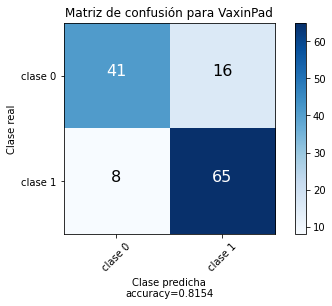

In [145]:
plot_confusion_matrix(cm           = np.array([[41, 16 ],
                                               [8, 65 ]]), 
                      normalize    = False,
                      target_names = ['clase 0', 'clase 1'],
                      title        = "Matriz de confusión para VaxinPad")